In [1]:
import re
import torch
from torch.utils.data.dataset import Dataset
import numpy as np
from PIL import Image
import os
from dataParser import getMaskFileName, getImg, getMask, getMasks
import torchvision.transforms as tr 
import random
import cv2

class AddPepperNoise(object):
    """增加椒盐噪声
    Args:
        snr （float）: Signal Noise Rate
        p (float): 概率值，依概率执行该操作
    """
 
    def __init__(self, snr, p=0.9):
        assert isinstance(snr, float) and (isinstance(p, float))    # 2020 07 26 or --> and
        self.snr = snr
        self.p = p
 
    def __call__(self, img):
        """
        Args:
            img (PIL Image): PIL Image
        Returns:
            PIL Image: PIL image.
        """
        if random.uniform(0, 1) < self.p:      #概率判断
            img_ = np.array(img).copy()
            h, w, c = img_.shape
            signal_pct = self.snr              #信噪比。信噪比0.9，说明信号占90%
            noise_pct = (1 - self.snr)         #噪声占比0.1
            mask = np.random.choice((0, 1, 2), size=(h, w, 1), p=[signal_pct, noise_pct/2., noise_pct/2.])
            mask = np.repeat(mask, c, axis=2)
            img_[mask == 1] = random.randint(0,255)   # 盐噪声
            img_[mask == 2] = random.randint(0,255)     # 椒噪声
            return Image.fromarray(img_.astype('uint8')).convert('RGB')
        else:
            return img

In [2]:
from PIL import Image
import numpy as np

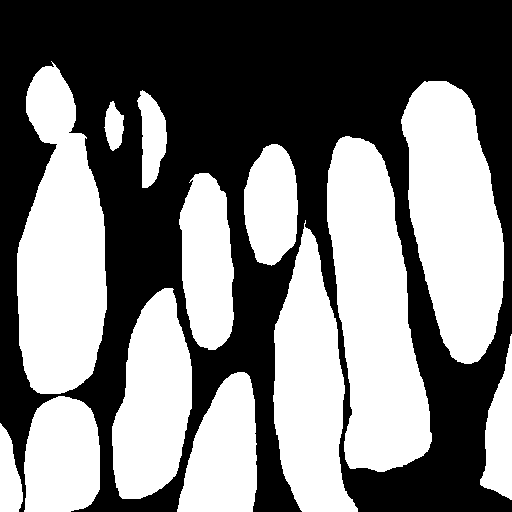

In [3]:
Image.fromarray((np.array(Image.open("./masks/27128_0004.png")) * 255).astype('uint8')).convert('RGB')

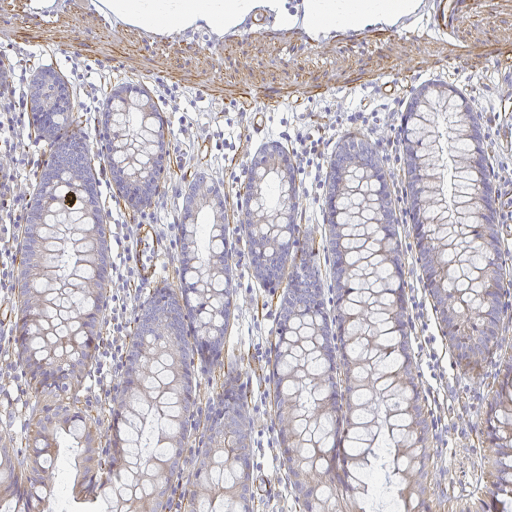

In [4]:
Image.open("./train/27128_0004.png")

In [5]:
images_path = "./train/27128_0004.png"
masks_path = "./masks/27128_0004.png"
img = cv2.imread(images_path)
mask = cv2.imread(masks_path, cv2.IMREAD_GRAYSCALE)  # 将彩色mask以二值图像形式读取
masked = cv2.add(img, np.zeros(np.shape(img), dtype=np.uint8), mask=mask)  #将image的相素值和mask像素值相加得到结果
masked = np.concatenate([masked[:,:,2:3],masked[:,:,1:2],masked[:,:,0:1]],axis=2)
# img = Image.fromarray(masked).convert('RGB')
# img

In [ ]:
cv2.minAreaRect

In [6]:
mask = cv2.imread(masks_path, cv2.IMREAD_GRAYSCALE)

In [180]:
import queue
def cfs(img):
    """传入二值化后的图片进行连通域分割"""
    pixdata = img.load()
    w,h = img.size
    visited = set()
    q = queue.Queue()
    offset = [(-1,-1),(0,-1),(1,-1),(-1,0),(1,0),(-1,1),(0,1),(1,1)]
    cuts = []
    for x in range(w):
        for y in range(h):
            x_axis = []
            #y_axis = []
            if pixdata[x,y] == 0 and (x,y) not in visited:
                q.put((x,y))
                visited.add((x,y))
            while not q.empty():
                x_p,y_p = q.get()
                for x_offset,y_offset in offset:
                    x_c,y_c = x_p+x_offset,y_p+y_offset
                    if (x_c,y_c) in visited:
                        continue
                    visited.add((x_c,y_c))
                    try:
                        if pixdata[x_c,y_c] == 0:
                            q.put((x_c,y_c))
                            x_axis.append(x_c)
                            #y_axis.append(y_c)
                    except:
                        pass
            if x_axis:
                min_x,max_x = min(x_axis),max(x_axis)
                if max_x - min_x >  20:
                    # 宽度小于3的认为是噪点，根据需要修改
                    cuts.append((min_x,max_x + 1))
    return cuts
 
def saveSmall(img_path, outDir, mask_path):
    temp = np.array(Image.open(mask_path))
    img = Image.open(img_path)
    temp[temp == 0] = 255
    temp[temp != 255] = 0
    cuts = cfs(Image.fromarray((temp).astype('uint8')).convert('L'))
    
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # 将彩色mask以二值图像形式读取
    masked = cv2.add(img, np.zeros(np.shape(img), dtype=np.uint8), mask=mask)  #将image的相素值和mask像素值相加得到结果
    masked = np.concatenate([masked[:,:,2:3],masked[:,:,1:2],masked[:,:,0:1]],axis=2)
    img = Image.fromarray(masked).convert('RGB')
    w, h = img.size
    pixdata = img.load()
    mask = Image.fromarray(mask)
    total_temp = []
    for i, item in enumerate(cuts):
        box = (item[0], 0, item[1], h)
        img_temp = img.crop(box)
        img_temp.save(outDir + str(i) + ".png")
        img_temp = np.array(img_temp)
        mask_temp = mask.crop(box)
        mask_temp = np.array(mask_temp)
        print(img_temp.shape)
        contours,heriachy = cv2.findContours(mask_temp,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_TC89_L1)
        areas = []
        for c in range(len(contours)):
            areas.append(cv2.contourArea(contours[c]))

        max_id = areas.index(max(areas))
        
        max_rect = cv2.minAreaRect(contours[max_id])
        max_box = cv2.boxPoints(max_rect)
        max_box = np.int0(max_box)
        
        rec_img = cv2.drawContours(img_temp,[max_box],0,(0,255,0),2)
        rec_mask = cv2.drawContours(mask_temp,[max_box],0,(0,255,0),2)

        pts1 = np.float32(max_box)
        pts2 = np.float32([[max_rect[0][0]+max_rect[1][1]/2, max_rect[0][1]+max_rect[1][0]/2],
                          [max_rect[0][0]-max_rect[1][1]/2, max_rect[0][1]+max_rect[1][0]/2],
                          [max_rect[0][0]-max_rect[1][1]/2, max_rect[0][1]-max_rect[1][0]/2],
                          [max_rect[0][0]+max_rect[1][1]/2, max_rect[0][1]-max_rect[1][0]/2]])
        M = cv2.getPerspectiveTransform(pts1,pts2)
        print(M)
        dst_img = cv2.warpPerspective(img_temp, M, (img_temp.shape[1],img_temp.shape[0]))
        dst_mask = cv2.warpPerspective(mask_temp, M, (mask_temp.shape[1],mask_temp.shape[0]))
        target_img = dst_img[int(pts2[2][1]):int(pts2[1][1]),int(pts2[2][0]):int(pts2[3][0]),:]
        target_mask = dst_mask[int(pts2[2][1]):int(pts2[1][1]),int(pts2[2][0]):int(pts2[3][0])]
        print(target_img.shape)
        total_temp.append([str(i) + ".png",target_img,target_mask,dst_img,dst_mask])
    return total_temp
        
        
        
        
# img = Image.open('out/51.png')
 
c = saveSmall("./train/27128_0004.png", 
          'outs/',
          "./masks/27128_0004.png")

(512, 55, 3)
[[-1.03063495e-15  1.00000000e+00 -4.24000000e+02]
 [-1.00000000e+00  4.96246818e-17  5.10000000e+02]
 [-2.20209526e-17  0.00000000e+00  1.00000000e+00]]
(22, 1, 3)
(512, 90, 3)
[[ 8.56075585e-17  1.00000000e+00 -1.82500000e+02]
 [-1.00000000e+00  0.00000000e+00  2.71500000e+02]
 [ 1.92376536e-18  0.00000000e+00  1.00000000e+00]]
(89, 90, 3)
(512, 76, 3)
[[-4.98225519e-16  1.00302096e+00 -1.89684248e+02]
 [-1.01351351e+00 -3.02821390e-16  2.64499969e+02]
 [-1.15685908e-18 -1.14488256e-18  1.00000000e+00]]
(75, 76, 3)
(512, 80, 3)
[[-1.93698835e-01  9.44893179e-01 -3.22867750e+02]
 [-9.71251083e-01 -2.25415977e-01  5.13601373e+02]
 [-3.28120978e-05 -8.07841592e-05  1.00000000e+00]]
(74, 63, 3)
(512, 30, 3)
[[-1.00000000e+00  0.00000000e+00  2.90000000e+01]
 [-7.28043788e-16 -1.00000000e+00  7.86000000e+02]
 [-9.33389472e-18  0.00000000e+00  1.00000000e+00]]
(210, 29, 3)
(512, 80, 3)
[[-1.00000000e+00  2.25080060e-18  7.90000000e+01]
 [-6.62021826e-16 -1.00000000e+00  8.8300

In [293]:
from tqdm.auto import tqdm
def get_subtarget(img_path, mask_path):
    img = Image.open(img_path)
    mask = Image.open(mask_path).convert('L')
    
    total_temp = []
    img_temp = np.array(img)
    mask_temp = np.array(mask)
    contours,heriachy = cv2.findContours(mask_temp,cv2.RETR_EXTERNAL,2)
    areas = []
    for c in range(len(contours)):
        areas.append(cv2.contourArea(contours[c]))
    for i,line in enumerate(contours):
        max_rect = cv2.minAreaRect(line)
        max_box = cv2.boxPoints(max_rect)
        max_box = np.int0(max_box)

        new_mask = cv2.drawContours(np.zeros_like(mask_temp), contours, i, 255, cv2.FILLED)
        pts1 = np.float32(max_box)
        pts2 = np.float32([[max_rect[0][0]+max_rect[1][1]/2, max_rect[0][1]+max_rect[1][0]/2],
                          [max_rect[0][0]-max_rect[1][1]/2, max_rect[0][1]+max_rect[1][0]/2],
                          [max_rect[0][0]-max_rect[1][1]/2, max_rect[0][1]-max_rect[1][0]/2],
                          [max_rect[0][0]+max_rect[1][1]/2, max_rect[0][1]-max_rect[1][0]/2]])
        M = cv2.getPerspectiveTransform(pts1,pts2)
        dst_img = cv2.warpPerspective(img_temp, M, (img_temp.shape[1],img_temp.shape[0]))
        dst_mask = cv2.warpPerspective(new_mask, M, (new_mask.shape[1],new_mask.shape[0]))
        target_img = dst_img[int(pts2[2][1]):int(pts2[1][1]),int(pts2[2][0]):int(pts2[3][0]),:]
        target_mask = dst_mask[int(pts2[2][1]):int(pts2[1][1]),int(pts2[2][0]):int(pts2[3][0])]
        target_img[target_mask != 255] = 0
        if np.sum(target_img) != 0:
            total_temp.append([target_img,target_mask])
    total_temp2 = []
    for i,line in enumerate(total_temp):
        img = np.concatenate([line[0][:,:,2:3],line[0][:,:,1:2],line[0][:,:,0:1]],axis=2)
        img = Image.fromarray(img).convert('RGB')
        mask = Image.fromarray(line[1]).convert('L')
        img.save("subimage/" + img_path.split("/")[-1].split(".")[0] + "_" + str(i) + ".png")
        mask.save("submask/" + img_path.split("/")[-1].split(".")[0] + "_" + str(i) + ".png")
        total_temp2.append(img_path.split("/")[-1].split(".")[0] + "_" + str(i) + ".png")
    return total_temp2
if 
dataset_folders = []
train_set = open("train.txt","r",encoding="utf-8").read()
for line in train_set.split("\n")[:-1]:
    dataset_folders.append(["train/" + line,"masks/" + line])
dataset_folders = np.array(dataset_folders)

total_file_path = []
for line in tqdm(dataset_folders):
    for line2 in get_subtarget(line[0],line[1]):
        total_file_path.append(line2)
fr = open("sub_target.txt","w")
fr.write("\n".join(total_file_path))
fr.close()

  0%|          | 0/2442 [00:00<?, ?it/s]

In [294]:
total_file_path

['8227_0003_0.png',
 '8227_0003_1.png',
 '8227_0003_2.png',
 '8227_0003_3.png',
 '8227_0003_4.png',
 '30765_0003_0.png',
 '24194_0007_0.png',
 '24194_0007_1.png',
 '24194_0007_2.png',
 '24194_0007_3.png',
 '24194_0007_4.png',
 '24194_0007_5.png',
 '24194_0007_6.png',
 '24194_0007_7.png',
 '14674_0002_0.png',
 '14674_0002_1.png',
 '14674_0002_2.png',
 '14674_0002_3.png',
 '14674_0002_4.png',
 '32231_0002_0.png',
 '14396_0001_0.png',
 '14396_0001_1.png',
 '14396_0001_2.png',
 '14396_0001_3.png',
 '14396_0001_4.png',
 '14396_0001_5.png',
 '22544_0004_0.png',
 '12026_0006_0.png',
 '20428_0004_0.png',
 '20428_0004_1.png',
 '20428_0004_2.png',
 '20428_0004_3.png',
 '20428_0004_4.png',
 '20428_0004_5.png',
 '20428_0004_6.png',
 '20428_0004_7.png',
 '22310_0006_0.png',
 '22310_0006_1.png',
 '22310_0006_2.png',
 '22310_0006_3.png',
 '22310_0006_4.png',
 '22310_0006_5.png',
 '22310_0006_6.png',
 '22310_0006_7.png',
 '22310_0006_8.png',
 '31406_0001_0.png',
 '31406_0001_1.png',
 '31406_0001_2.png

In [299]:
print("\n".join(total_file_path))

8227_0003_0.png
8227_0003_1.png
8227_0003_2.png
8227_0003_3.png
8227_0003_4.png
30765_0003_0.png
24194_0007_0.png
24194_0007_1.png
24194_0007_2.png
24194_0007_3.png
24194_0007_4.png
24194_0007_5.png
24194_0007_6.png
24194_0007_7.png
14674_0002_0.png
14674_0002_1.png
14674_0002_2.png
14674_0002_3.png
14674_0002_4.png
32231_0002_0.png
14396_0001_0.png
14396_0001_1.png
14396_0001_2.png
14396_0001_3.png
14396_0001_4.png
14396_0001_5.png
22544_0004_0.png
12026_0006_0.png
20428_0004_0.png
20428_0004_1.png
20428_0004_2.png
20428_0004_3.png
20428_0004_4.png
20428_0004_5.png
20428_0004_6.png
20428_0004_7.png
22310_0006_0.png
22310_0006_1.png
22310_0006_2.png
22310_0006_3.png
22310_0006_4.png
22310_0006_5.png
22310_0006_6.png
22310_0006_7.png
22310_0006_8.png
31406_0001_0.png
31406_0001_1.png
31406_0001_2.png
31406_0001_3.png
31406_0001_4.png
31406_0001_5.png
31406_0001_6.png
31406_0001_7.png
31406_0001_8.png
31406_0001_9.png
31406_0001_10.png
31406_0001_11.png
31406_0001_12.png
31406_0001_13.pn

In [289]:
dataset_folders

array([['train/8227_0003.png', 'masks/8227_0003.png'],
       ['train/2793_0008.png', 'masks/2793_0008.png'],
       ['train/30765_0003.png', 'masks/30765_0003.png'],
       ...,
       ['train/1157_0000.png', 'masks/1157_0000.png'],
       ['train/21358_0007.png', 'masks/21358_0007.png'],
       ['train/2668_0000.png', 'masks/2668_0000.png']], dtype='<U20')

In [266]:
Image.fromarray(c[9][0])

In [268]:
c[0][0].shape

(115, 75, 3)

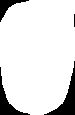

In [256]:
Image.fromarray(c[0][1])

In [15]:
import cv2
import numpy as np
 
img = cv2.imread('./masks/27128_0004.png')
 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#二值化，注意有两个返回值，阈值和结果
thresh, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
contours, hierachy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
 
rect = cv2.minAreaRect(contours[1])
#cv2.drawContours(img, contours, 1, (0, 0, 255), 2)这一步可以画轮廓
#rect是一个Rotated Rect旋转的矩形，矩形的起始坐标xy，长宽，旋转角度
#注意box给的是小数，但坐标必须是整数，要转化一下
box = cv2.boxPoints(rect)
 
box = np.round(box).astype('int64')
cv2.drawContours(img, [newbox], 0, (0, 0, 255), 2)

IndexError: tuple index out of range

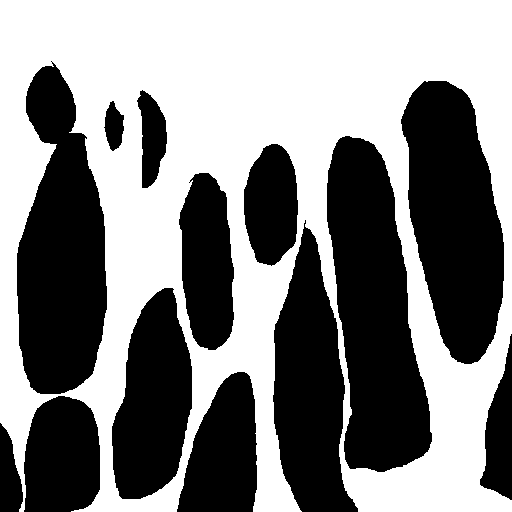

In [109]:
temp = np.array(Image.open("./masks/27128_0004.png"))
temp[temp == 0] = 255
temp[temp != 255] = 0
Image.fromarray((temp).astype('uint8')).convert('L')

In [ ]:
import cv2
import numpy as np
 
img1= cv2.imread('./train/27128_0004.png')
img2= cv2.imread('./masks/27128_0004.png')
 
img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
# img = img1
contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
areas = []
 
for c in range(len(contours)):
    areas.append(cv2.contourArea(contours[c]))

max_id = areas.index(max(areas))
 
max_rect = cv2.minAreaRect(contours[max_id])
max_box = cv2.boxPoints(max_rect)
max_box = np.int0(max_box)
img2 = cv2.drawContours(img2,[max_box],0,(0,255,0),2)
 
pts1 = np.float32(max_box)
pts2 = np.float32([[max_rect[0][0]+max_rect[1][1]/2, max_rect[0][1]+max_rect[1][0]/2],
                  [max_rect[0][0]-max_rect[1][1]/2, max_rect[0][1]+max_rect[1][0]/2],
                  [max_rect[0][0]-max_rect[1][1]/2, max_rect[0][1]-max_rect[1][0]/2],
                  [max_rect[0][0]+max_rect[1][1]/2, max_rect[0][1]-max_rect[1][0]/2]])
M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img2, M, (img2.shape[1],img2.shape[0]))
 
# 此处可以验证 max_box点的顺序
# color = [(0, 0, 255),(0,255,0),(255,0,0),(255,255,255)]
# i = 0
# for point in pts2:
#     print(point)
#     cv2.circle(dst, tuple(point), 2, color[i], 4)
#     i+=1

# target = dst[int(pts2[2][1]):int(pts2[1][1]),int(pts2[2][0]):int(pts2[3][0]),:]


cv2.imshow('img2',img2)
cv2.imshow('dst',dst)
# cv2.imshow('target',target)
cv2.waitKey()
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x5625452c4020) is not the object's thread (0x562545c02360).
Cannot move to target thread (0x5625452c4020)

QObject::moveToThread: Current thread (0x5625452c4020) is not the object's thread (0x562545c02360).
Cannot move to target thread (0x5625452c4020)

QObject::moveToThread: Current thread (0x5625452c4020) is not the object's thread (0x562545c02360).
Cannot move to target thread (0x5625452c4020)

QObject::moveToThread: Current thread (0x5625452c4020) is not the object's thread (0x562545c02360).
Cannot move to target thread (0x5625452c4020)

QObject::moveToThread: Current thread (0x5625452c4020) is not the object's thread (0x562545c02360).
Cannot move to target thread (0x5625452c4020)

QObject::moveToThread: Current thread (0x5625452c4020) is not the object's thread (0x562545c02360).
Cannot move to target thread (0x5625452c4020)

QObject::moveToThread: Current thread (0x5625452c4020) is not the object's thread (0x562545c02360).
Cannot move to tar

In [55]:
np.sum(img * 255)

49388752